<a href="https://colab.research.google.com/github/zippyzippy0/miniproject/blob/main/_notebooks/assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install osmnx
%pip install --upgrade osmnx
%pip install hdx-python-api


In [2]:
import osmnx as ox
import os
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

In [3]:
!git clone https://github.com/zippyzippy0/miniproject.git


Cloning into 'miniproject'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 173 (delta 88), reused 149 (delta 77), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 4.05 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [4]:
import sys
sys.path.append("/content/miniproject")  # repo root, contains fynesse/
import fynesse


In [5]:
import os, subprocess, importlib, sys

def load_repo(repo, module):
    local = repo.split("/")[-1]
    if not os.path.exists(local):
        subprocess.run(["git", "clone", f"https://github.com/{repo}.git"], check=True)
    else:
        subprocess.run(["git", "-C", local, "pull"], check=True)
    if os.path.join(local) not in sys.path:
        sys.path.insert(0, local)
    mod = importlib.import_module(module)
    importlib.reload(mod)
    return mod

# usage
fynesse = load_repo("zippyzippy0/miniproject", "fynesse")


<Axes: >

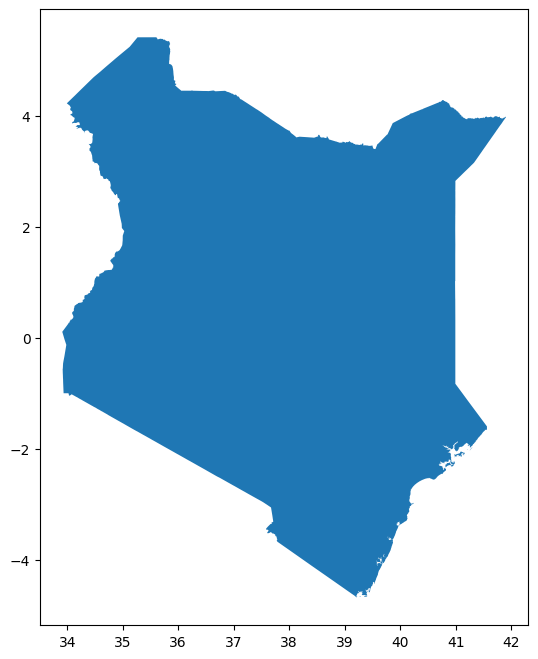

In [9]:
kenya = gpd.read_file("/content/miniproject/data/ken_admbnda_adm0_iebc_20191031.shp")

kenya.plot(figsize=(10,8))

<Axes: >

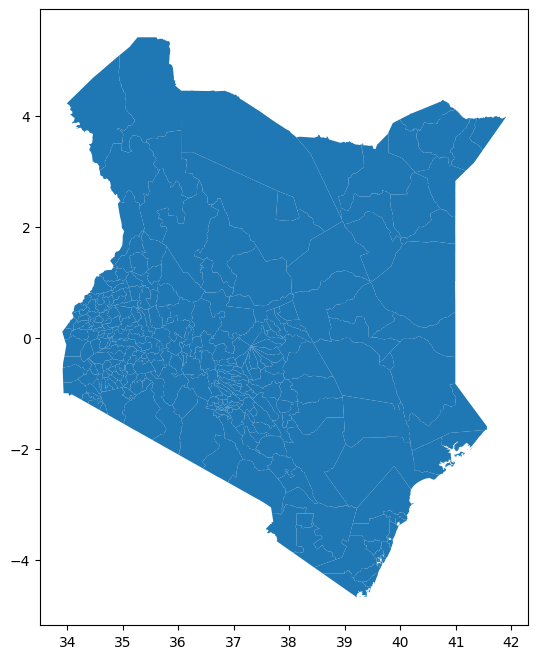

In [10]:
subcounties = gpd.read_file("/content/miniproject/data/ken_admbnda_adm2_iebc_20191031.shp")

subcounties.plot(figsize=(10,8))

<Axes: >

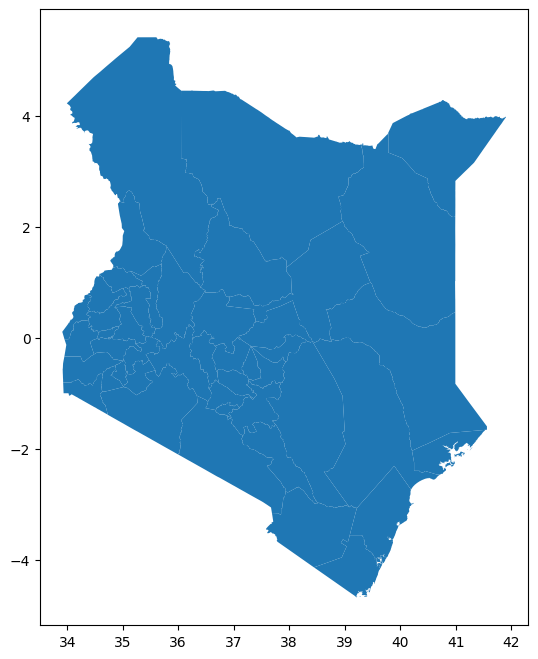

In [51]:
counties = gpd.read_file("/content/miniproject/data/ken_admbnda_adm1_iebc_20191031.shp")

counties.plot(figsize=(10,8))

In [15]:
import requests
import geopandas as gpd
from shapely.geometry import Point

def fetch_osm_amenities(bbox, amenities):
    """Fetches OSM amenities within a bbox using list comprehension."""
    query = f"""
    [out:json][timeout:180];
    nwr["amenity"~"{'|'.join(amenities)}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
    out center;
    """
    url = "http://overpass-api.de/api/interpreter"
    try:
        response = requests.get(url, params={"data": query}, timeout=180)
        response.raise_for_status()
        data = response.json().get("elements", [])

        features = [
            {
                "name": el["tags"].get("name", "Unknown"),
                "amenity": el["tags"].get("amenity", "Unknown"),
                "geometry": Point(el.get("lon", el.get("center", {}).get("lon")), el.get("lat", el.get("center", {}).get("lat")))
            } for el in data if "lon" in el or "center" in el
        ]

        return gpd.GeoDataFrame(features, crs="EPSG:4326")

    except requests.exceptions.RequestException as e:
        print(f"Overpass API request failed: {e}")
        return gpd.GeoDataFrame(columns=["name", "amenity", "geometry"], geometry="geometry", crs="EPSG:4326")


In [16]:
kenya_bbox = [-4.72, 33.89, 5.33, 41.89]
points = fetch_osm_amenities(kenya_bbox, ["school", "hospital"])

kenya_union = counties.unary_union
points = points[points.within(kenya_union)]

/tmp/ipython-input-1254254055.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  kenya_union = counties.unary_union


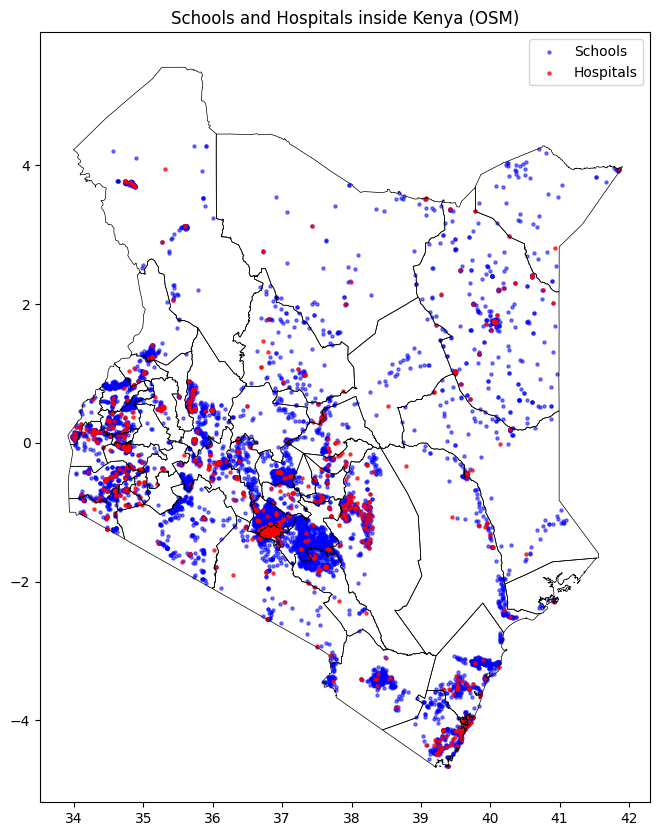

In [17]:
fig, ax = plt.subplots(figsize=(12,10))
counties.boundary.plot(ax=ax, color="black", linewidth=0.5)
points[points["amenity"]=="school"].plot(ax=ax, color="blue", markersize=5, alpha=0.5, label="Schools")
points[points["amenity"]=="hospital"].plot(ax=ax, color="red", markersize=5, alpha=0.7, label="Hospitals")
plt.legend()
plt.title("Schools and Hospitals inside Kenya (OSM)")
plt.show()

/tmp/ipython-input-1708014273.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_union = county.unary_union


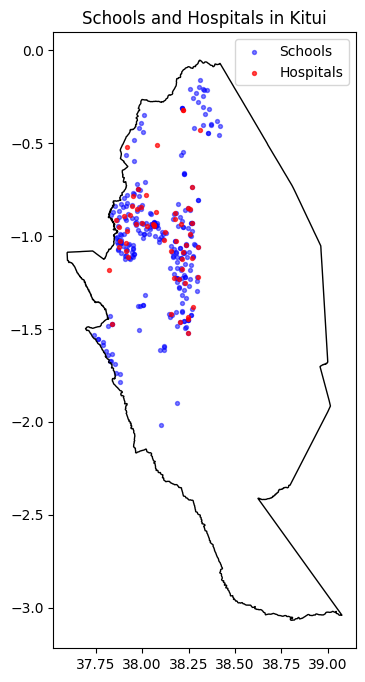

In [18]:
county_name = "Kitui"
county = counties[counties["ADM1_EN"] == county_name]
bbox = county.total_bounds
points = fetch_osm_amenities([bbox[1], bbox[0], bbox[3], bbox[2]], ["school", "hospital"])

county_union = county.unary_union
points = points[points.within(county_union)]

fig, ax = plt.subplots(figsize=(10,8))
county.boundary.plot(ax=ax, color="black", linewidth=1)
points[points["amenity"]=="school"].plot(ax=ax, color="blue", markersize=8, alpha=0.5, label="Schools")
points[points["amenity"]=="hospital"].plot(ax=ax, color="red", markersize=8, alpha=0.7, label="Hospitals")
plt.legend()
plt.title(f"Schools and Hospitals in {county_name}")
plt.show()

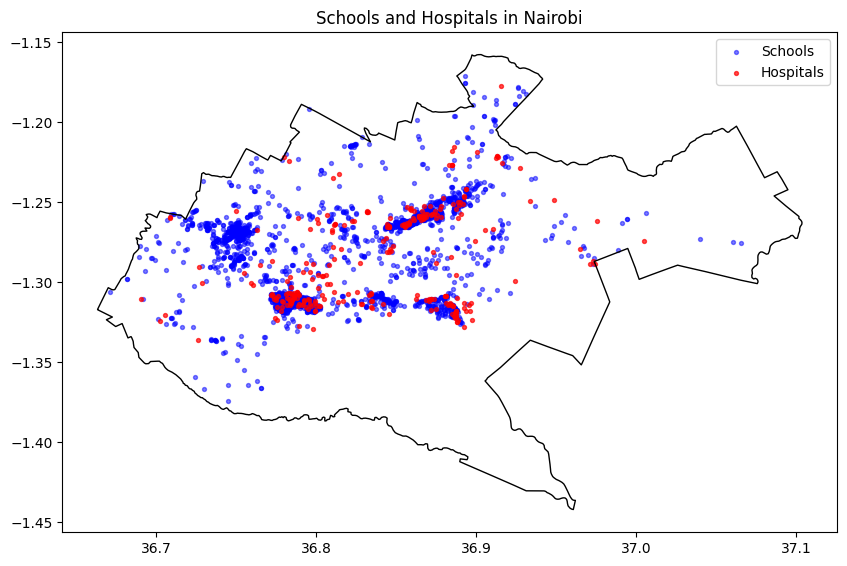

In [19]:
import matplotlib.pyplot as plt
import geopandas as gpd

county_name = "Nairobi"
county = counties[counties["ADM1_EN"] == county_name]

if not county.empty:
    minx, miny, maxx, maxy = county.geometry.iloc[0].bounds

    bbox = [miny, minx, maxy, maxx]

    points = fetch_osm_amenities(bbox, ["school", "hospital"])
    if not points.empty:
        county_union = county.geometry.union_all()
        points = points[points.within(county_union)]

        fig, ax = plt.subplots(figsize=(10,8))
        county.boundary.plot(ax=ax, color="black", linewidth=1)
        points[points["amenity"]=="school"].plot(ax=ax, color="blue", markersize=8, alpha=0.5, label="Schools")
        points[points["amenity"]=="hospital"].plot(ax=ax, color="red", markersize=8, alpha=0.7, label="Hospitals")
        plt.legend()
        plt.title(f"Schools and Hospitals in {county_name}")
        plt.show()
    else:
        print(f"No amenities data fetched for {county_name}.")
else:
    print(f"County '{county_name}' not found.")

In [22]:
health = gpd.read_file("/content/drive/MyDrive/miniproject/data/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp")
schools = gpd.read_file("/content/drive/MyDrive/miniproject/data/hotosm_ken_education_facilities_points_shp/hotosm_ken_education_facilities_points_shp.shp")

In [29]:
print(len(health))
print(len(schools))

1895
9638


In [41]:
counties.head()

Shape_Leng  Shape_Area          ADM1_EN ADM1_PCODE ADM1_REF ADM1ALT1EN  \
0    5.932315    0.884732          Baringo      KE030     None       None   
1    2.922220    0.198099            Bomet      KE036     None       None   
2    3.062486    0.245058          Bungoma      KE039     None       None   
3    2.670396    0.147178            Busia      KE040     None       None   
4    3.888933    0.244432  Elgeyo-Marakwet      KE028     None       None   

  ADM1ALT2EN ADM0_EN ADM0_PCODE       date    validOn validTo  \
0       None   Kenya         KE 2017-11-03 2019-10-31     NaT   
1       None   Kenya         KE 2017-11-03 2019-10-31     NaT   
2       None   Kenya         KE 2017-11-03 2019-10-31     NaT   
3       None   Kenya         KE 2017-11-03 2019-10-31     NaT   
4       None   Kenya         KE 2017-11-03 2019-10-31     NaT   

                                            geometry  
0  POLYGON ((35.7839 1.65557, 35.78496 1.65554, 3...  
1  POLYGON ((35.4736 -0.3992, 35.47845 -0.40663, ...  
2  POLYGON ((34.62017 1.10228, 34.62133 1.1016, 3...  
3  POLYGON ((34.36097 0.7773, 34.36172 0.77696, 3...  
4  POLYGON ((35.69818 1.28225, 35.69788 1.27905, ...

In [30]:
health.head()

name name_en   amenity building healthcare  \
0                Jubilee Centre Karen    None    clinic     None     clinic   
1             Rongo University Clinic    None    clinic     None     clinic   
2  Lea Toto Community (Mukuru Reuben)    None    clinic     None     clinic   
3     Mwangaza Ulio na Tumaini Clinic    None  hospital     None   hospital   
4            Mayaka Healthcare Center    None    clinic     None     clinic   

  healthca_1 operator_t capacity_p addr_full addr_city source name_sw  \
0       None       None       None      None   Nairobi   None    None   
1       None       None       None      None      None   None    None   
2       None  religious       None      None      None   None    None   
3       None       None       None      None      None   None    None   
4       None       None       None      None      None   None    None   

        osm_id osm_type                   geometry  
0   7501513238    nodes  POINT (36.75752 -1.34078)  
1   6191765988    nodes  POINT (34.61278 -0.82495)  
2    949597526    nodes  POINT (36.86948 -1.31591)  
3   8891939521    nodes   POINT (36.8919 -1.25107)  
4  10735348497    nodes  POINT (34.79691 -0.91105)

In [31]:
schools.head()

name name_en amenity building operator_t capacity_p  \
0          Rongo University    None  school     None       None       None   
1       Toku Primary School    None  school     None       None       None   
2      Kanyawanga Secondary    None  school     None       None       None   
3    Kangeso Primary School    None  school     None       None       None   
4  Kangeso Secondary School    None  school     None       None       None   

  addr_full addr_city source name_sw      osm_id osm_type  \
0      None      None   None    None  6191765987    nodes   
1      None      None   None    None  6191765990    nodes   
2      None      None   None    None  6191766020    nodes   
3      None      None   None    None  6191766014    nodes   
4      None      None   None    None  6191766015    nodes   

                    geometry  
0  POINT (34.61075 -0.82602)  
1  POINT (34.61929 -0.83412)  
2  POINT (34.57844 -0.76546)  
3  POINT (34.54581 -0.74222)  
4  POINT (34.55932 -0.74921)

In [40]:
kenya.head()

Shape_Leng  Shape_Area ADM0_EN ADM0_PCODE ADM0_REF ADM0ALT1EN ADM0ALT2EN  \
0   44.052413   48.098756   Kenya         KE     None       None       None   

        date    validOn validTo  \
0 2017-11-03 2019-10-31     NaT   

                                            geometry  
0  MULTIPOLYGON (((39.22308 -4.66901, 39.22034 -4...

Text(0.5, 1.0, 'Health Facilities')

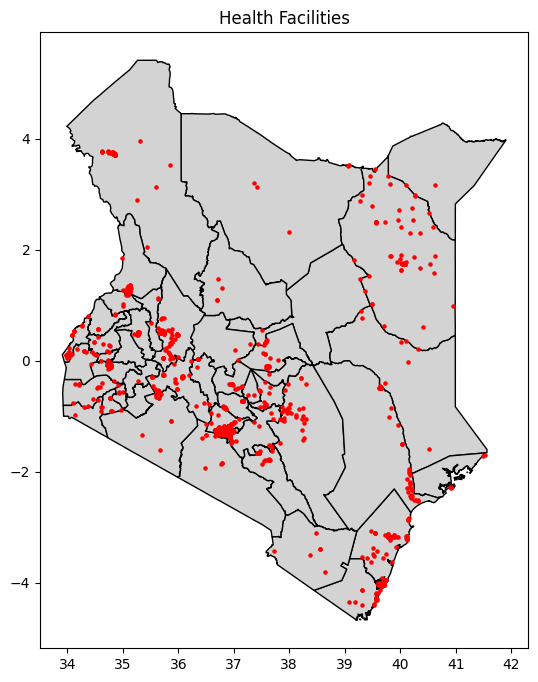

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
counties.plot(ax=ax, color="lightgrey", edgecolor="black")
health.plot(ax=ax, color="red", markersize=5)
ax.set_title("Health Facilities")

Text(0.5, 1.0, 'Health Facilities')

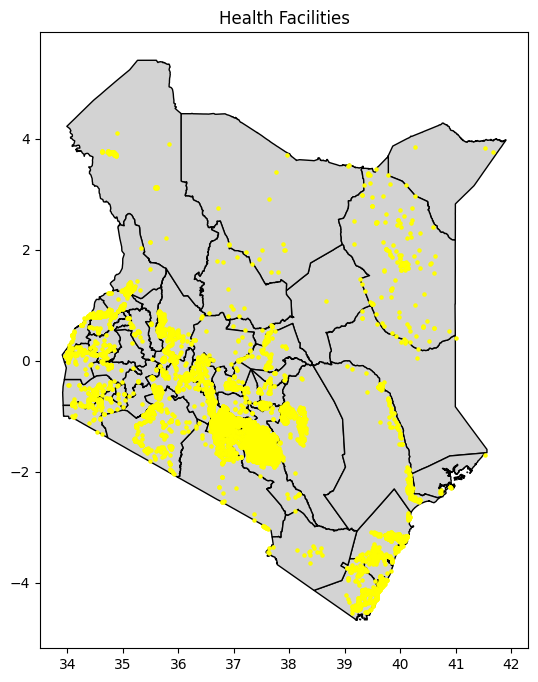

In [37]:
fig, ax = plt.subplots(figsize=(20, 8))
counties.plot(ax=ax, color="lightgrey", edgecolor="black")
schools.plot(ax=ax, color="yellow", markersize=5)
ax.set_title("Health Facilities")

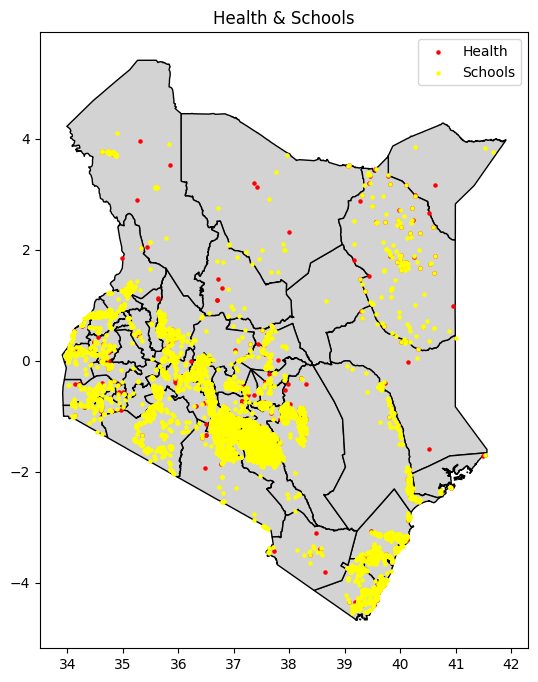

In [36]:
fig, ax = plt.subplots(figsize=(20, 8))
counties.plot(ax=ax, color="lightgrey", edgecolor="black")
health.plot(ax=ax, color="red", markersize=5, label="Health")
schools.plot(ax=ax, color="yellow", markersize=5, label="Schools")
ax.legend()
ax.set_title("Health & Schools")
plt.show()

In [54]:
points = health.to_crs(counties.crs)
joined = gpd.sjoin(points, counties, how="inner", predicate="within")
counts = joined.groupby("ADM1_EN").size().reset_index(name="count")


In [57]:
print(len(points), "points in total")
print(len(joined), "points joined to counties")

# Check distinct counties matched
print(joined["ADM1_EN"].nunique(), "unique counties in joined data")
print(joined["ADM1_EN"].value_counts().tail(10))

1895 points in total
1883 points joined to counties
45 unique counties in joined data
ADM1_EN
Bungoma            3
Elgeyo-Marakwet    3
Lamu               3
Nyamira            3
Nyandarua          2
Kirinyaga          2
Mandera            2
Tharaka-Nithi      1
Kericho            1
Vihiga             1
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

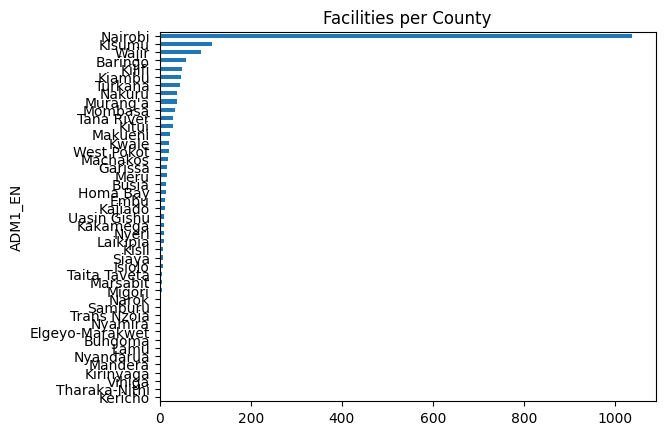

In [56]:
plt.figure(figsize=(10,5))
counts.sort_values("count").plot(kind="barh", x="ADM1_EN", y="count", legend=False)
plt.title("Facilities per County")
plt.show()

In [58]:
import plotly.express as px
fig = px.choropleth_mapbox(
    counts.merge(counties, on="ADM1_EN").set_geometry("geometry"),
    geojson=counties.__geo_interface__,
    locations=counts["ADM1_EN"],
    color="count",
    featureidkey="properties.ADM1_EN",
    hover_name="ADM1_EN",
    hover_data=["count"],
    mapbox_style="carto-positron", zoom=5, center={"lat":0.1,"lon":37.9}
)
fig.show()

In [65]:
points_s = schools.to_crs(counties.crs)
joined_s = gpd.sjoin(points_s, counties, how="inner", predicate="within")
counts_s = joined_s.groupby("ADM1_EN").size().reset_index(name="count")


In [67]:
print(len(points_s), "points in total")
print(len(joined_s), "points joined to counties")

# Check distinct counties matched
print(joined_s["ADM1_EN"].nunique(), "unique counties in joined data")
print(joined_s["ADM1_EN"].value_counts().tail(10))

9638 points in total
9556 points joined to counties
47 unique counties in joined data
ADM1_EN
Kirinyaga          14
Samburu            14
Marsabit           14
Lamu                8
Kericho             8
Nyamira             7
Elgeyo-Marakwet     5
Bomet               3
Mandera             3
Nandi               1
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

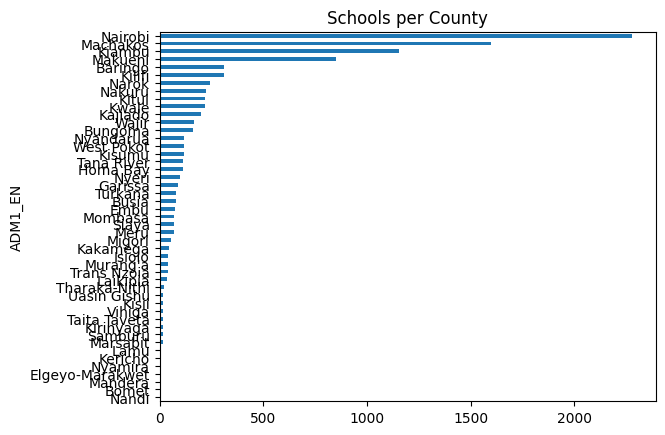

In [69]:
plt.figure(figsize=(10,5))
counts_s.sort_values("count").plot(kind="barh", x="ADM1_EN", y="count", legend=False)
plt.title("Schools per County")
plt.show()

In [70]:
import plotly.express as px
fig = px.choropleth_mapbox(
    counts_s.merge(counties, on="ADM1_EN").set_geometry("geometry"),
    geojson=counties.__geo_interface__,
    locations=counts_s["ADM1_EN"],
    color="count",
    featureidkey="properties.ADM1_EN",
    hover_name="ADM1_EN",
    hover_data=["count"],
    mapbox_style="carto-positron", zoom=5, center={"lat":0.1,"lon":37.9}
)
fig.show()